## Exercício: Modelo de Linguagem com auto-atenção e máscaras causais

Seguimos na mesma linha de treinar um modelo de linguagem a partir dos textos de Machado de Assis.

Neste exercício, vamos treinar um modelo de linguagem com auto-atenção e com máscara causal. A máscara causal é necessária para que o modelo não tenha acesso a palavras futuras, que é a abordagem usada por grandes modelos de linguagem, como o GPT.

Use a implementação matricial de auto-atenção da aula passada (sobre atenção).

### Modificações necessárias

* Adicione a máscara causal na função `forward` da cabeça de auto-atenção.
* Modificar tokenizador para considerar <sos> (start-of-sequence) e <eos> (end-of-sequence).
* Modifique o nosso dataset para retornar inputs (uma lista de tokens de tamanho $n$), targets (uma lista de tokens de tamanho $n$ deslocada para a esquerda em 1 token). Exemplo `input = [1, 2, 3, 4]`, `target = [2, 3, 4, 5]` para a sequência `[1, 2, 3, 4, 5]` com `seq_len=4`, por exemplo (Ver slide 72).

### Extra
* MultiHeadAttention: modifique a cabeça de auto-atenção para ter múltiplas cabeças. Isso não é obrigatório, mas pode ser interessante para ver como o modelo se comporta.
* Diagrama da geração: fazer diagrama que mostre os passos da geração de tokens (conforme slide 69).
* Verificar o dataloader e ver se está tudo funcionando, especialmente o deslocamento dos tokens à esquerda.

### Dicas

* Use como base o vídeo do Karpathy: https://www.youtube.com/watch?v=kCc8FmEb1nY. Observe que, no vídeo, ele primeiro implementa um modelo bi-grama, depois um modelo de linguagem com auto-atenção. O modelo de auto-atenção é implementado por volta do minuto 40, mas vale a pena assistir o vídeo todo.
* Use esta implementação como base: https://colab.research.google.com/drive/1vFTg4MSXVJwNSzPjaCcvmqhxTP7gK7HA?usp=sharing. Observe como o modelo é organizado e como a máscara é implementada na classe MultiHeadAttention.
* Use `context_size=9`

In [26]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [27]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Tokenizer

In [28]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

C:\Users\limalucas\AppData\Local\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [29]:
special_tokens_dict = {'additional_special_tokens': ['<sos>', '<eos>']}
tokenizer.add_special_tokens(special_tokens_dict)

2

In [30]:
print(tokenizer.encode('<sos> <eos>'))
print(tokenizer.vocab_size)

[101, 29794, 29795, 102]
29794


## Dados

Vamos usar o mesmo dataset do Machado de Assis.



In [31]:
#!git clone https://github.com/ethelbeluzzi/projetomachado

In [80]:
import os

DATA_PATH = os.path.join("projetomachado", "textonormalizado1000.txt")

# A príncipio, não estamos limpando as linhas
with open(DATA_PATH, "r", encoding="utf-8") as data_file:
    lines = [line for line in data_file]

# É possível voltar a um texto monolítico juntando as linhas.
full_data = ' '.join(lines)
#full_data = full_data[:100000] # Limitando para testes
full_data = tokenizer(full_data).input_ids[1:-1]
len(full_data)

4903405

In [81]:
from sklearn.model_selection import train_test_split
train_text, val_text = train_test_split(full_data, test_size=0.2, random_state=18, shuffle=False)
len(train_text), len(val_text)

(3922724, 980681)

## Classe do dataset

Utilize o Tokenizer do Bert na classe Dataset.
Defina um tamanho de sequencia/contexto.

In [82]:
from torch.utils.data import Dataset

context_size = 8  # 7 palavras de entrada. O target é a próxima palavra. <sos> no começo e <eos> no final
"""TODO: Preparar o dataset"""
class TextDataset(Dataset):
    def __init__(self, text, context_size):
        self.pairs = self.create_context_target_pairs(text, context_size)

    def create_context_target_pairs(self, text, context_size):
        context_target_pairs = []

        # Gerar pares (contexto, target) ignorando targets desconhecidos
        for i in range(len(text) - context_size):
            context = [29794] + text[i:i + context_size]
            target = text[i:i + context_size] + [29795]

            context_target_pairs.append((context, target))

        return context_target_pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        context, target = self.pairs[idx]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

In [83]:
"""TODO: implemente a classe do dataset"""

train_data = TextDataset(train_text, context_size)
val_data = TextDataset(val_text, context_size)
len(train_data), len(val_data)

(3922716, 980673)

In [84]:
# Exemplo de acesso a um item do dataset
for i in range(3):
  sample_context, sample_target = train_data[i]
  print(f"Contexto: {sample_context}, Target: {sample_target}")

Contexto: tensor([29794,   205,   213,  7073,  6538, 22321, 22352, 21748, 22317]), Target: tensor([  205,   213,  7073,  6538, 22321, 22352, 21748, 22317, 29795])
Contexto: tensor([29794,   213,  7073,  6538, 22321, 22352, 21748, 22317,   250]), Target: tensor([  213,  7073,  6538, 22321, 22352, 21748, 22317,   250, 29795])
Contexto: tensor([29794,  7073,  6538, 22321, 22352, 21748, 22317,   250, 22301]), Target: tensor([ 7073,  6538, 22321, 22352, 21748, 22317,   250, 22301, 29795])


## DataLoader

In [85]:
from torch.utils.data import DataLoader
batch_size = 512
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
sample = next(iter(train_loader))

In [86]:
context_batch, target_batch = sample

print(f"Dimensões do contexto no lote: {context_batch.shape}")
print(f"Dimensões do alvo no lote: {target_batch.shape}")
context_batch, target_batch

Dimensões do contexto no lote: torch.Size([512, 9])
Dimensões do alvo no lote: torch.Size([512, 9])


(tensor([[29794, 22280,   712,  ...,   547,   125,   222],
         [29794,   117, 17891,  ...,   119,   119,   119],
         [29794,   122,   146,  ...,  9630, 22278,  1202],
         ...,
         [29794,   504,  4536,  ..., 22305,   117,   122],
         [29794,   222,   644,  ...,  8175,   146,   347],
         [29794,   529,   675,  ...,   179,   125,  5288]]),
 tensor([[22280,   712,  3667,  ...,   125,   222, 29795],
         [  117, 17891,  4640,  ...,   119,   119, 29795],
         [  122,   146,  9857,  ..., 22278,  1202, 29795],
         ...,
         [  504,  4536,  8849,  ...,   117,   122, 29795],
         [  222,   644,  7821,  ...,   146,   347, 29795],
         [  529,   675, 10089,  ...,   125,  5288, 29795]]))

## Modelo

In [87]:
class Head(nn.Module):
    """ uma cabeça de auto-atenção """
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))  # Máscara causal

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape  # batch, seq_len, emb_size
        k = self.key(x)   # (B, T, head_size)
        q = self.query(x) # (B, T, head_size)
        # Calcular scores de atenção
        wei = q @ k.transpose(-2, -1) * C**-0.5  # (B, T, head_size) @ (B, head_size, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)
        # Agregação ponderada dos valores
        v = self.value(x)  # (B, T, head_size)
        out = wei @ v  # (B, T, T) @ (B, T, head_size) -> (B, T, head_size)
        return out

class MultiHeadAttention(nn.Module):
    """ múltiplas cabeças de auto-atenção em paralelo """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # Concatena as saídas de todas as cabeças
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ uma camada linear simples seguida por uma não-linearidade """
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Bloco Transformer: comunicação seguida de computação """
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class Microtransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)  # normalização final
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)  # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T, C)
        x = tok_emb + pos_emb  # (B, T, C)
        x = self.blocks(x)  # (B, T, C)
        x = self.ln_f(x)  # (B, T, C)
        logits = self.lm_head(x)  # (B, T, vocab_size)

        return logits

In [100]:
# hyperparameters
vocab_size = 29796
batch_size = 512 
block_size = 9
n_embd = 128
n_head = 4
n_layer = 4
dropout = 0.3

In [101]:
model = Microtransformer()
model

Microtransformer(
  (token_embedding_table): Embedding(29796, 128)
  (position_embedding_table): Embedding(9, 128)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.3, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.3, inplace=False)
        )
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=T

In [102]:
#!pip install torchinfo -q

In [103]:
import torchinfo
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
Microtransformer                              --
├─Embedding: 1-1                              3,813,888
├─Embedding: 1-2                              1,152
├─Sequential: 1-3                             --
│    └─Block: 2-1                             --
│    │    └─MultiHeadAttention: 3-1           65,664
│    │    └─FeedFoward: 3-2                   131,712
│    │    └─LayerNorm: 3-3                    256
│    │    └─LayerNorm: 3-4                    256
│    └─Block: 2-2                             --
│    │    └─MultiHeadAttention: 3-5           65,664
│    │    └─FeedFoward: 3-6                   131,712
│    │    └─LayerNorm: 3-7                    256
│    │    └─LayerNorm: 3-8                    256
│    └─Block: 2-3                             --
│    │    └─MultiHeadAttention: 3-9           65,664
│    │    └─FeedFoward: 3-10                  131,712
│    │    └─LayerNorm: 3-11                   256
│    │    └─LayerNorm:

In [104]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [105]:
model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=100) #"""TODO CrossEntropy""""
def calculate_perplexity(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_words = 0

    with torch.no_grad():
        for contexts, targets in dataloader:
            contexts, targets = contexts.to(device), targets.to(device)

            # Forward pass
            outputs = model(contexts)
            
            # Ajustar as dimensões
            outputs = outputs.view(-1, outputs.size(-1))  # (batch_size * seq_len, vocab_size)
            targets = targets.view(-1)  # (batch_size * seq_len)
            # Calculate the loss
            loss = criterion(outputs, targets)

            # Accumulate the loss and the number of words
            total_loss += loss.item() #* contexts.size(0)
            #total_words += targets.size(0)

    # Compute the average loss
    avg_loss = total_loss / len(dataloader)

    # Calculate the perplexity
    perplexity = np.exp(avg_loss)

    return perplexity

In [106]:
train_perplexity = calculate_perplexity(model, train_loader, criterion, device)
print(f"Perplexidade no conjunto de treino: {train_perplexity:.2f}")

Perplexidade no conjunto de treino: 34376.86


Epoch 1/10 - Train Loss: 0.0105 - Val Loss: 0.0094 - Train Accuracy: 0.2180 - Val Accuracy: 0.2519 - Time: 8.85 min
Epoch 2/10 - Train Loss: 0.0090 - Val Loss: 0.0090 - Train Accuracy: 0.2593 - Val Accuracy: 0.2684 - Time: 8.90 min
Epoch 3/10 - Train Loss: 0.0087 - Val Loss: 0.0088 - Train Accuracy: 0.2710 - Val Accuracy: 0.2766 - Time: 8.84 min
Epoch 4/10 - Train Loss: 0.0085 - Val Loss: 0.0087 - Train Accuracy: 0.2778 - Val Accuracy: 0.2817 - Time: 8.84 min
Epoch 5/10 - Train Loss: 0.0083 - Val Loss: 0.0087 - Train Accuracy: 0.2825 - Val Accuracy: 0.2847 - Time: 8.90 min
Epoch 6/10 - Train Loss: 0.0082 - Val Loss: 0.0086 - Train Accuracy: 0.2860 - Val Accuracy: 0.2871 - Time: 8.85 min
Epoch 7/10 - Train Loss: 0.0082 - Val Loss: 0.0086 - Train Accuracy: 0.2887 - Val Accuracy: 0.2887 - Time: 8.84 min
Epoch 8/10 - Train Loss: 0.0081 - Val Loss: 0.0086 - Train Accuracy: 0.2911 - Val Accuracy: 0.2905 - Time: 8.88 min
Epoch 9/10 - Train Loss: 0.0081 - Val Loss: 0.0085 - Train Accuracy: 0.2

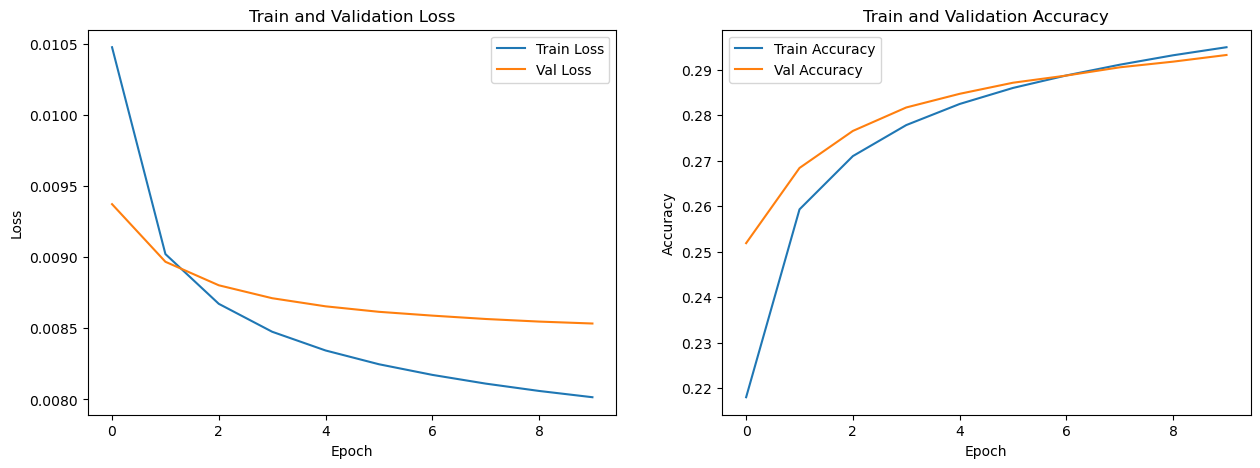

In [107]:
import time
import torch.optim as optim
import matplotlib.pyplot as plt

epochs = 10
lr = 1e-4  # Taxa de aprendizado
criterion = nn.CrossEntropyLoss(ignore_index=100)  # Função de perda CrossEntropy

optimizer = optim.AdamW(model.parameters(), lr=lr)  # Otimizador AdamW

model.to(device)

# Função de Treinamento
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for contexts, targets in dataloader:
        contexts, targets = contexts.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(contexts)
        
        # Ajustar as dimensões
        outputs = outputs.view(-1, outputs.size(-1))  # (batch_size * seq_len, vocab_size)
        targets = targets.view(-1)  # (batch_size * seq_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() #* contexts.size(0)

        # Cálculo da acurácia
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = correct / total
    return epoch_loss / len(dataloader.dataset), accuracy

# Função de Avaliação
def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for contexts, targets in dataloader:
            contexts, targets = contexts.to(device), targets.to(device)

            outputs = model(contexts)
            
            # Ajustar as dimensões
            outputs = outputs.view(-1, outputs.size(-1))  # (batch_size * seq_len, vocab_size)
            targets = targets.view(-1)  # (batch_size * seq_len)

            loss = criterion(outputs, targets)
            epoch_loss += loss.item() #* contexts.size(0)

            # Cálculo da acurácia
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = correct / total
    return epoch_loss / len(dataloader.dataset), accuracy

# Loop de Treinamento e Avaliação com Tempo por Época
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        start_time = time.time()  # Captura o tempo inicial da época

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        end_time = time.time()  # Captura o tempo final da época
        epoch_time = (end_time - start_time) / 60  # Tempo da época em minutos

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - "
              f"Train Accuracy: {train_acc:.4f} - Val Accuracy: {val_acc:.4f} - "
              f"Time: {epoch_time:.2f} min")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Treinamento e Avaliação
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs, device)

# Plotar Gráficos de Loss e Acurácia
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot de Loss
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Val Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Train and Validation Loss')
    axs[0].legend()

    # Plot de Acurácia
    axs[1].plot(train_accuracies, label='Train Accuracy')
    axs[1].plot(val_accuracies, label='Val Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Train and Validation Accuracy')
    axs[1].legend()

    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [108]:
""" TODO: calcule a perplexidade final no dataset de validação """
val_perplexity = calculate_perplexity(model, val_loader, criterion, device)
print(f"Perplexidade no conjunto de validação: {val_perplexity:.2f}")

Perplexidade no conjunto de validação: 78.89


## Geração sem temperatura

In [110]:
# Função para gerar texto a partir de um modelo
def generate_text(model, context, max_length, context_size, device):
    model.eval()

    generated_indices = []
    context = context
    # Começar a geração de texto
    for i in range(max_length):
        # Obter o contexto atual
        if i==0:
            input_context = torch.tensor([29794]+context[-context_size:], dtype=torch.long, device=device).unsqueeze(0)
        else:
            input_context = torch.tensor(context[-context_size-1:], dtype=torch.long, device=device).unsqueeze(0)
        # Forward pass
        with torch.no_grad():
            output = model(input_context) # output.shape: (1, seq_len, vocab_size)
        
        # Obter o índice da palavra mais provável para o próximo token
        next_token_logits = output[:, -1, :]  # (1, vocab_size)
        predicted_index = torch.argmax(next_token_logits, dim=-1).item()

        # Adicionar o índice ao texto gerado
        generated_indices.append(predicted_index)

        # Atualizar o contexto
        context.append(predicted_index)
        context = context[-context_size:]

    # Decodificar os índices gerados para texto usando o tokenizer do BERT
    generated_text = tokenizer.decode(generated_indices)#, skip_special_tokens=True)

    return tokenizer.decode(context[:context_size]) + ' ' + generated_text

# Função para pegar um contexto aleatório do val_data
def get_random_context(val_text, context_size):
    # Escolha um índice aleatório para começar
    start_index = random.randint(0, len(val_text) - context_size)
    context = val_text[start_index:start_index + context_size]

    return context

# Exemplo de uso
context_size = 8
for i in range(5):
  context = get_random_context(val_text, context_size)
  context_text = tokenizer.decode(context)
  print("Contexto Inicial:", context_text)

  max_length = 150
  generated_text = generate_text(model, context, max_length, context_size, device)
  print(f"Texto gerado: {generated_text}")
  print("-" * 100 )

Contexto Inicial: , pedindo charutos, indo ao
Texto gerado: ........ <eos> ##tm, who, www. nead. unama. b!....................................................................................................................................
----------------------------------------------------------------------------------------------------
Contexto Inicial: ##risto e estenderlhe a mão ; voltou
Texto gerado: ........ <eos> ##he a mão, e, se não é preciso... é preciso que não....................................................................................................................................
----------------------------------------------------------------------------------------------------
Contexto Inicial: Lívia. Que foi, emendo
Texto gerado: ........ <eos> ##o, é que não se pode fazer crer que não seja, nem por isso é possível que não é?..............................................................................................................................
-----------

## Geração com temperatura

In [118]:
import torch.nn.functional as F

# Função para gerar texto a partir de um modelo com temperatura
def generate_text(model, context, max_length, context_size, device, temperature=1.0):
    model.eval()

    generated_indices = []
    context = context

    # Começar a geração de texto
    for i in range(max_length):
        # Obter o contexto atual
        if i == 0:
            input_context = torch.tensor([29794] + context[-context_size:], dtype=torch.long, device=device).unsqueeze(0)
        else:
            input_context = torch.tensor(context[-context_size-1:], dtype=torch.long, device=device).unsqueeze(0)

        # Forward pass
        with torch.no_grad():
            output = model(input_context)  # output.shape: (1, seq_len, vocab_size)

        # Aplicar a temperatura
        next_token_logits = output[:, -1, :] / temperature  # Ajustar logits pela temperatura
        probabilities = F.softmax(next_token_logits, dim=-1)  # Converter logits em probabilidades

        # Amostrar o próximo token a partir das probabilidades ajustadas
        predicted_index = torch.multinomial(probabilities, num_samples=1).item()

        # Adicionar o índice ao texto gerado
        generated_indices.append(predicted_index)

        # Atualizar o contexto
        context.append(predicted_index)
        context = context[-context_size:]

    # Decodificar os índices gerados para texto usando o tokenizer do BERT
    generated_text = tokenizer.decode(generated_indices)

    return tokenizer.decode(context[:context_size]) + ' ' + generated_text

# Função para pegar um contexto aleatório do val_data
def get_random_context(val_text, context_size):
    # Escolha um índice aleatório para começar
    start_index = random.randint(0, len(val_text) - context_size)
    context = val_text[start_index:start_index + context_size]

    return context

# Exemplo de uso
context_size = 8
for i in range(5):
    context = get_random_context(val_text, context_size)
    context_text = tokenizer.decode(context)
    print("Contexto Inicial:", context_text)

    max_length = 100
    temperature = 0.7 # Ajuste a temperatura conforme necessário
    generated_text = generate_text(model, context, max_length, context_size, device, temperature=temperature)
    print(f"Texto gerado: {generated_text}")
    print("-" * 100)


Contexto Inicial: confiança. Não é preciso definir esta instituição
Texto gerado: ##eiros e eu. Mas não gosto ama <eos> ##ou que não era mal alinha. Não ; é preciso que uma é que a églória do mar, tendo a alma o ressentimento de doçura. E as cartas do Comendadorauld e o leader, não nos havíamos em que eu vá... D. Benedita, não, que não, quando o nosso caso é se explica o que é que a minha casta, a generosidade dos cabeleireiros e eu. Mas não gosto ama
----------------------------------------------------------------------------------------------------
Contexto Inicial: escrito. Em primeiro lugar, fique
Texto gerado: .......! <eos> ##t alcançou, é que é que ele não fizesse esquecer as minhas excetinas, Pedro e não são? A este era um homem ; que nenhum! E eu acho que é de melhor! Oh! é muito ser acusado, agora!! Mirto! Vocês!? És tu! disse Batista ; é isto, meu filho! D. Helena.........................!
--------------------------------------------------------------------------------------